# 개선된 U-Net 모델 만들기

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import keras

<IPython.core.display.Javascript object>

## 데이터셋 준비

[KITTI semantic segmentation 데이터셋](http://www.cvlibs.net/datasets/kitti/eval_semseg.php?benchmark=semantics2015)을 사용합니다. 

- 데이터 증강 함수를 구현합니다.
  - 50%의 확률로 좌우반전
  - 50%의 확률로 RandomSizedCrop
  - 입력이미지를 224X224로 resize
  - 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.

In [2]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize


def build_augmentation(is_train=True):
    flip_mine = HorizontalFlip(p=0.5)
    crop_mine = RandomSizedCrop(
        min_max_height=(300, 370),
        w2h_ratio=370 / 1242,
        height=224,
        width=224,
        p=0.5,
    )
    resize_mine = Resize(width=224, height=224)
    if is_train:
        return Compose([flip_mine, crop_mine, resize_mine])
    return Compose([resize_mine])

<IPython.core.display.Javascript object>

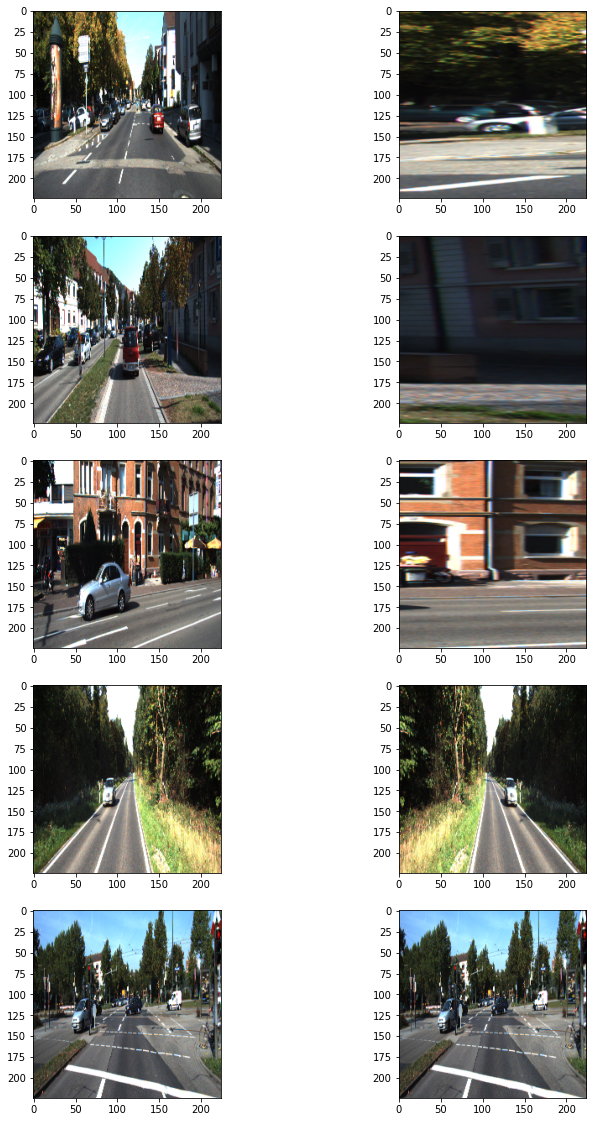

<IPython.core.display.Javascript object>

In [3]:
dir_path = os.getenv("HOME") + "/aiffel/semantic_segmentation/data/training"

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image": image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(resized["image"])  
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(processed["image"]) 

plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    """
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    """

    def __init__(
        self,
        dir_path,
        batch_size=4,
        img_size=(224, 224, 3),
        output_size=(224, 224),
        is_train=True,
        augmentation=None,
    ):
        """
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        """
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고
        # 출력은 semantic label입니다.
        batch_data = self.data[index * self.batch_size : (index + 1) * self.batch_size]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8) * 1
            data = {"image": _input, "mask": _output}
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"] / 255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

<IPython.core.display.Javascript object>

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_gen = KittiGenerator(dir_path, augmentation=augmentation)
test_gen = KittiGenerator(dir_path, augmentation=test_preproc, is_train=False)

<IPython.core.display.Javascript object>

## U-Net 모델 구현 및 학습

### 모델 구현

In [6]:
def build_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(inputs)
    conv1 = Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool1)
    conv2 = Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool2)
    conv3 = Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(
        512, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool3)
    conv4 = Conv2D(
        512, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(
        1024, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool4)
    conv5 = Conv2D(
        1024, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv5)

    # Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(
        512, 2, activation="relu", strides=(2, 2), kernel_initializer="he_normal"
    )(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(
        512, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge6)
    conv6 = Conv2D(
        512, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv6)
    up7 = Conv2DTranspose(
        256, 2, activation="relu", strides=(2, 2), kernel_initializer="he_normal"
    )(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge7)
    conv7 = Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv7)
    up8 = Conv2DTranspose(
        128, 2, activation="relu", strides=(2, 2), kernel_initializer="he_normal"
    )(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge8)
    conv8 = Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv8)
    up9 = Conv2DTranspose(
        64, 2, activation="relu", strides=(2, 2), kernel_initializer="he_normal"
    )(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge9)
    conv9 = Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv9)
    conv9 = Conv2D(
        2, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv9)
    conv10 = Conv2D(1, 1, activation="sigmoid")(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model


<IPython.core.display.Javascript object>

In [7]:
build_unet().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

<IPython.core.display.Javascript object>

### 모델 학습

In [8]:
EPOCHS = 15

<IPython.core.display.Javascript object>

In [9]:
checkpoint_path = os.getenv("HOME") + "/aiffel/semantic_segmentation/checkpoint_unet"
checkpointer = keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor="val_loss", save_best_only=True
)

<IPython.core.display.Javascript object>

In [10]:
model = build_unet()
model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy")
model.fit(
    train_gen,
    validation_data=test_gen,
    steps_per_epoch=len(train_gen),
    epochs=EPOCHS,
    callbacks=[checkpointer],
)

# model_path = os.getenv("HOME") + "/aiffel/semantic_segmentation/seg_model_unet.h5"
# model.save(model_path)

Epoch 1/15
43/43 [==============================] - 19s 222ms/step - loss: 0.3218 - val_loss: 0.1216
INFO:tensorflow:Assets written to: /aiffel/aiffel/semantic_segmentation/checkpoint_unet/assets
Epoch 2/15
43/43 [==============================] - 9s 214ms/step - loss: 0.1124 - val_loss: 0.0952
INFO:tensorflow:Assets written to: /aiffel/aiffel/semantic_segmentation/checkpoint_unet/assets
Epoch 3/15
43/43 [==============================] - 9s 210ms/step - loss: 0.1103 - val_loss: 0.1100
Epoch 4/15
43/43 [==============================] - 9s 211ms/step - loss: 0.0816 - val_loss: 0.0751
INFO:tensorflow:Assets written to: /aiffel/aiffel/semantic_segmentation/checkpoint_unet/assets
Epoch 5/15
43/43 [==============================] - 9s 208ms/step - loss: 0.0773 - val_loss: 0.0830
Epoch 6/15
43/43 [==============================] - 9s 208ms/step - loss: 0.0741 - val_loss: 0.0783
Epoch 7/15
43/43 [==============================] - 9s 211ms/step - loss: 0.0737 - val_loss: 0.0791
Epoch 8/15
43/

<IPython.core.display.Javascript object>

### 성능 확인

In [11]:
model = tf.keras.models.load_model(checkpoint_path)

<IPython.core.display.Javascript object>

In [12]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print("IoU : %f" % iou_score)
    return iou_score

<IPython.core.display.Javascript object>

In [13]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"] / 255, axis=0))
    # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = (output[0].numpy() >= 0.5).astype(np.uint8).squeeze(-1) * 255
    prediction = output / 255  # 도로로 판단한 영역

    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert("RGBA")
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert("RGBA")
    output = Image.blend(background, output, alpha=0.5)
    output.show()  # 도로로 판단한 영역을 시각화!

    if label_path:
        label_img = imread(label_path)
        label_data = {"image": label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8) * 1  # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

<IPython.core.display.Javascript object>

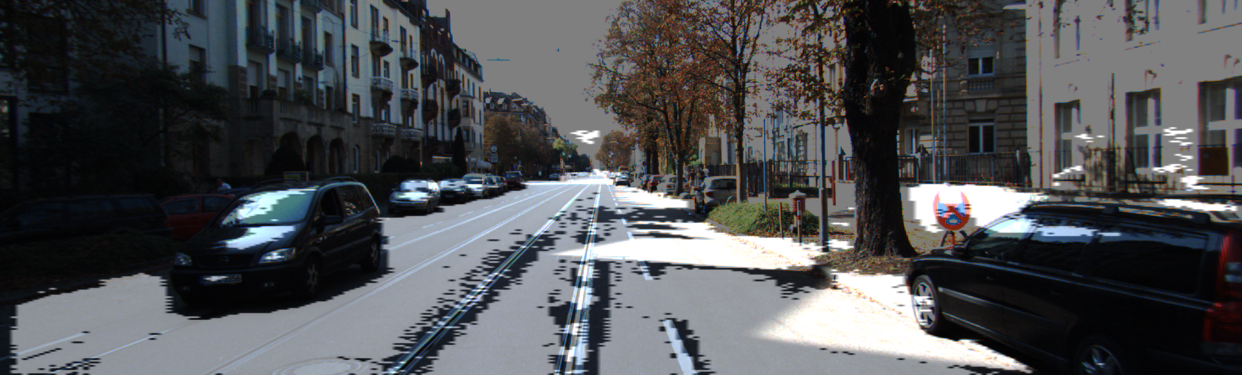

IoU : 0.729761


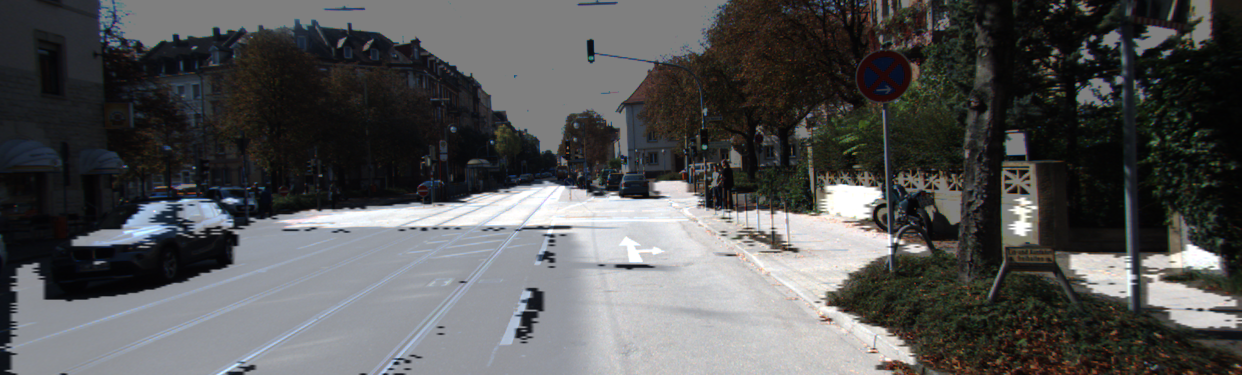

IoU : 0.777434


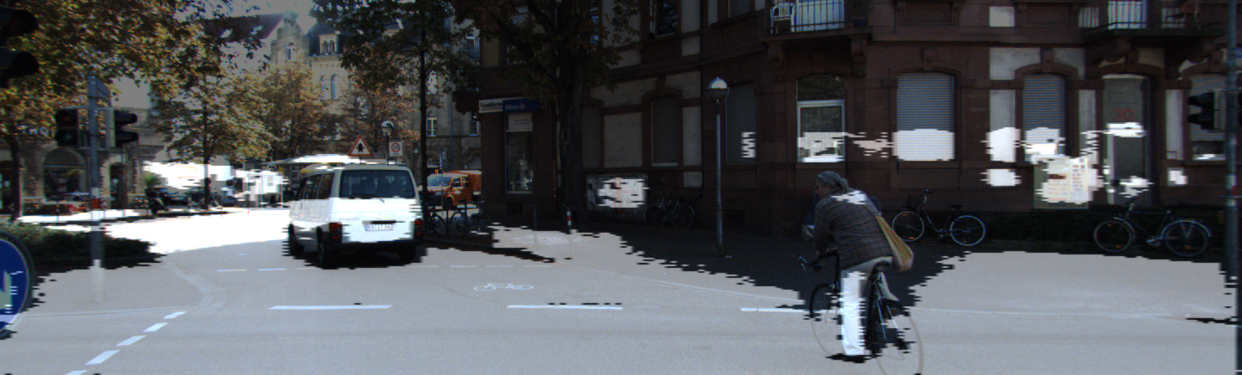

IoU : 0.632956


<IPython.core.display.Javascript object>

In [14]:
for i in range(3):
    output, prediction, target = get_output(
        model,
        test_preproc,
        image_path=dir_path + f"/image_2/00{str(i).zfill(4)}_10.png",
        output_path=dir_path + f"./result_{str(i).zfill(3)}.png",
        label_path=dir_path + f"/semantic/00{str(i).zfill(4)}_10.png",
    )

    calculate_iou_score(target, prediction)

## U-Net++ 모델 구현 및 학습

![unet_xx](img/g10_unet_xx.png)

_[1] Z. Zhou, M. M. Rahman Siddiquee, N. Tajbakhsh, and J. Liang, “Unet++: A nested u-net architecture for medical image segmentation,” Lect. Notes Comput. Sci. (including Subser. Lect. Notes Artif. Intell. Lect. Notes Bioinformatics), vol. 11045 LNCS, pp. 3–11, 2018, doi: 10.1007/978-3-030-00889-5_1._

U-Net++는 U-Net의 구조에 skip connection과 upsampling을 추가하여 성능 향상을 이루어낸 네트워크입니다.

### 모델 구현
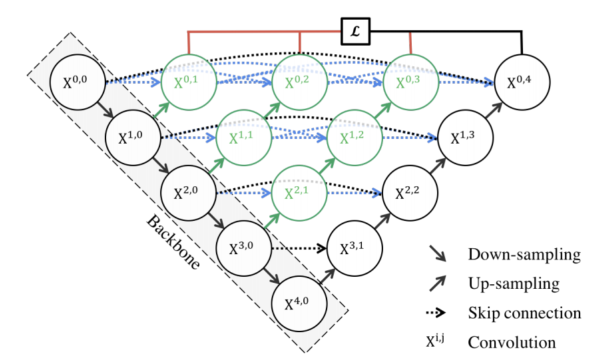

In [15]:
kwargs_conv = {
    "kernel_size": 3,
    "activation": "relu",
    "padding": "same",
    "kernel_initializer": "he_normal",
}

kwargs_upsample = {
    "kernel_size": 2,
    "activation": "relu",
    "strides": (2, 2),
    "kernel_initializer": "he_normal",
}


def vgg_block(x, filters, dropout=False):
    x = Conv2D(filters, **kwargs_conv)(x)
    x = Conv2D(filters, **kwargs_conv)(x)
    if dropout:
        x = Dropout(0.5)(x)
    return x


def build_unet_xx(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # n, 0 (backbone)
    conv0_0 = vgg_block(inputs, 64)
    pool0_0 = MaxPooling2D(pool_size=(2, 2))(conv0_0)

    conv1_0 = vgg_block(pool0_0, 128)
    pool1_0 = MaxPooling2D(pool_size=(2, 2))(conv1_0)

    conv2_0 = vgg_block(pool1_0, 256)
    pool2_0 = MaxPooling2D(pool_size=(2, 2))(conv2_0)

    conv3_0 = vgg_block(pool2_0, 512, dropout=True)
    pool3_0 = MaxPooling2D(pool_size=(2, 2))(conv3_0)

    conv4_0 = vgg_block(pool3_0, 512, dropout=True)

    # n, 1
    up1_0 = Conv2DTranspose(128, **kwargs_upsample)(conv1_0)
    conv0_1_con = concatenate([conv0_0, up1_0], axis=3)
    conv0_1 = Conv2D(128, **kwargs_conv)(conv0_1_con)

    up2_0 = Conv2DTranspose(256, **kwargs_upsample)(conv2_0)
    conv1_1_con = concatenate([conv1_0, up2_0], axis=3)
    conv1_1 = Conv2D(256, **kwargs_conv)(conv1_1_con)

    up3_0 = Conv2DTranspose(512, **kwargs_upsample)(conv3_0)
    conv2_1_con = concatenate([conv2_0, up3_0], axis=3)
    conv2_1 = Conv2D(512, **kwargs_conv)(conv2_1_con)

    up4_0 = Conv2DTranspose(512, **kwargs_upsample)(conv4_0)
    conv3_1_con = concatenate([conv3_0, up4_0], axis=3)
    conv3_1 = Conv2D(512, **kwargs_conv)(conv3_1_con)

    # n, 2
    up1_1 = Conv2DTranspose(256, **kwargs_upsample)(conv1_1)
    conv0_2_con = concatenate([conv0_0, conv0_1, up1_1], axis=3)
    conv0_2 = Conv2D(256, **kwargs_conv)(conv0_2_con)

    up2_1 = Conv2DTranspose(512, **kwargs_upsample)(conv2_1)
    conv1_2_con = concatenate([conv1_0, conv1_1, up2_1], axis=3)
    conv1_2 = Conv2D(512, **kwargs_conv)(conv1_2_con)

    up3_1 = Conv2DTranspose(512, **kwargs_upsample)(conv3_1)
    conv2_2_con = concatenate([conv2_0, conv2_1, up3_1], axis=3)
    conv2_2 = Conv2D(512, **kwargs_conv)(conv2_2_con)

    # n, 3
    up1_2 = Conv2DTranspose(512, **kwargs_upsample)(conv1_2)
    conv0_3_con = concatenate([conv0_0, conv0_1, conv0_2, up1_2], axis=3)
    conv0_3 = Conv2D(512, **kwargs_conv)(conv0_3_con)

    up2_2 = Conv2DTranspose(512, **kwargs_upsample)(conv2_2)
    conv1_3_con = concatenate([conv1_0, conv1_1, conv1_2, up2_2], axis=3)
    conv1_3 = Conv2D(512, **kwargs_conv)(conv1_3_con)

    # n, 4
    up1_3 = Conv2DTranspose(512, **kwargs_upsample)(conv1_3)
    conv0_4_con = concatenate([conv0_0, conv0_1, conv0_2, conv0_3, up1_3], axis=3)
    conv0_4 = Conv2D(512, **kwargs_conv)(conv0_4_con)

    conv = Conv2D(1, 1, activation="sigmoid")(conv0_4)
    model = Model(inputs=inputs, outputs=conv, name="unet_xx")
    return model

<IPython.core.display.Javascript object>

In [16]:
build_unet_xx().summary()

Model: "unet_xx"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_41[0][0]                  
____________________________________________________________________________________________

<IPython.core.display.Javascript object>

### 모델 학습

In [17]:
from keras import backend as K


def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(
        y_true, y_pred
    )

<IPython.core.display.Javascript object>

In [18]:
checkpoint_path = os.getenv("HOME") + "/aiffel/semantic_segmentation/checkpoint_unet_xx"
checkpointer = keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor="val_loss", save_best_only=True
)

<IPython.core.display.Javascript object>

In [19]:
model_xx = build_unet_xx()
model_xx.compile(
    optimizer=Adam(1e-4), loss=bce_dice_loss, metrics=["binary_crossentropy"]
)
model_xx.fit(
    train_gen,
    validation_data=test_gen,
    steps_per_epoch=len(train_gen),
    epochs=EPOCHS,
    callbacks=[checkpointer],
)

# model_path = os.getenv("HOME") + "/aiffel/semantic_segmentation/seg_model_unet_xx.h5"
# model_xx.save(model_path)

Epoch 1/15
43/43 [==============================] - 252s 4s/step - loss: 0.0583 - binary_crossentropy: 0.5458 - val_loss: -0.4058 - val_binary_crossentropy: 0.2168
INFO:tensorflow:Assets written to: /aiffel/aiffel/semantic_segmentation/checkpoint_unet_xx/assets
Epoch 2/15
43/43 [==============================] - 186s 4s/step - loss: -0.3626 - binary_crossentropy: 0.2079 - val_loss: -0.4866 - val_binary_crossentropy: 0.2091
INFO:tensorflow:Assets written to: /aiffel/aiffel/semantic_segmentation/checkpoint_unet_xx/assets
Epoch 3/15
43/43 [==============================] - 187s 4s/step - loss: -0.3641 - binary_crossentropy: 0.2384 - val_loss: -0.5646 - val_binary_crossentropy: 0.1546
INFO:tensorflow:Assets written to: /aiffel/aiffel/semantic_segmentation/checkpoint_unet_xx/assets
Epoch 4/15
43/43 [==============================] - 186s 4s/step - loss: -0.5294 - binary_crossentropy: 0.1375 - val_loss: -0.7469 - val_binary_crossentropy: 0.1169
INFO:tensorflow:Assets written to: /aiffel/aiff

<IPython.core.display.Javascript object>

### 성능 확인

In [20]:
model_xx = tf.keras.models.load_model(
    checkpoint_path, custom_objects={"bce_dice_loss": bce_dice_loss}
)

<IPython.core.display.Javascript object>

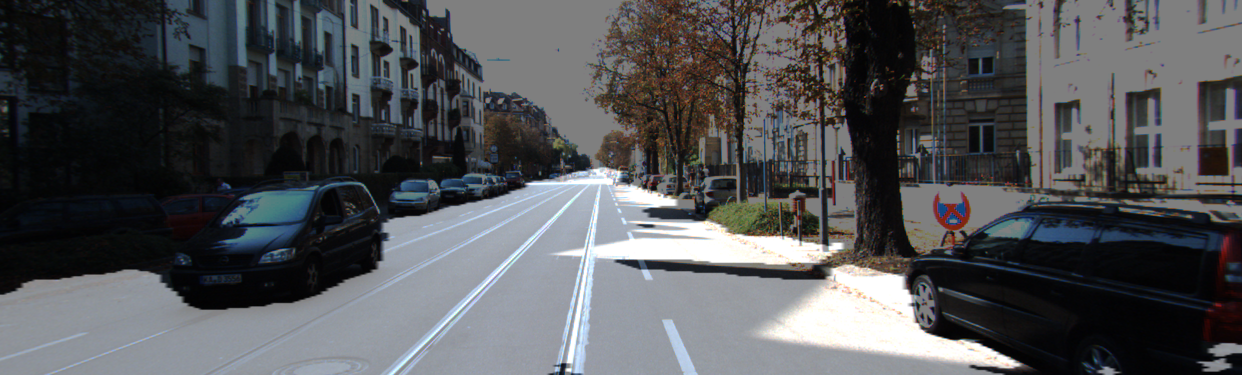

IoU : 0.902623


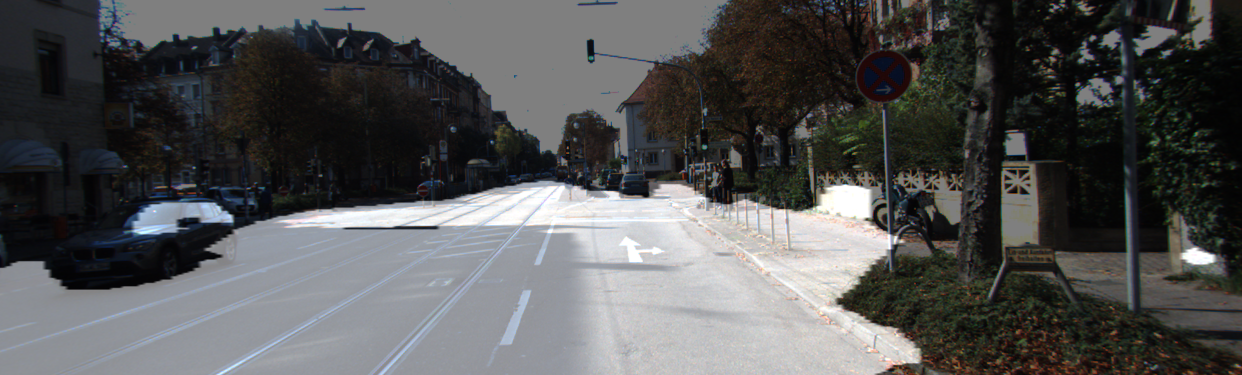

IoU : 0.828502


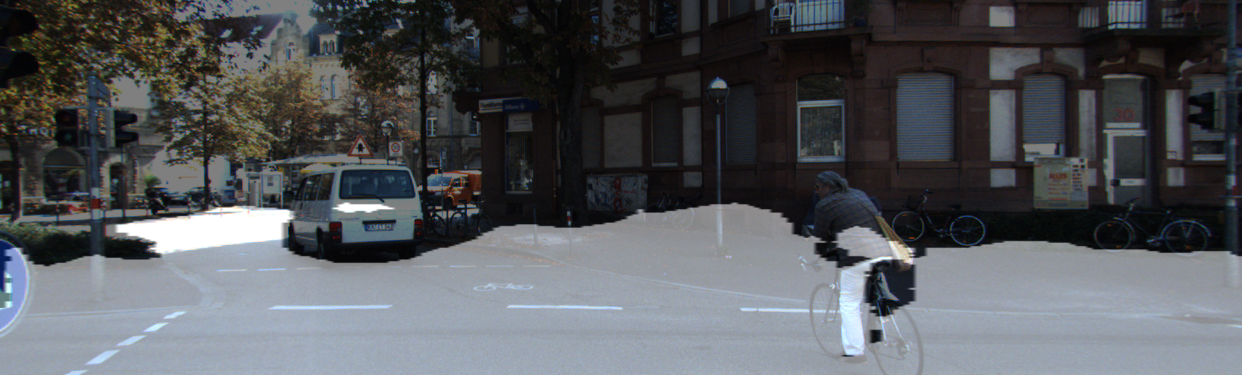

IoU : 0.609996


<IPython.core.display.Javascript object>

In [21]:
for i in range(3):
    output, prediction, target = get_output(
        model_xx,
        test_preproc,
        image_path=dir_path + f"/image_2/00{str(i).zfill(4)}_10.png",
        output_path=dir_path + f"./result_{str(i).zfill(3)}.png",
        label_path=dir_path + f"/semantic/00{str(i).zfill(4)}_10.png",
    )

    calculate_iou_score(target, prediction)

## U-Net & U-Net++ 결과 비교

| Image Sample | U-Net | U-Net++ |
| --- | :-: | :-: |
| #1 | ![unet01](img/g10_res01.png) IoU: 0.730 | ![unetxx01](img/g10_res04.png) IoU: 0.903 |
| #2 | ![unet02](img/g10_res02.png) IoU: 0.777 | ![unetxx02](img/g10_res05.png) IoU: 0.829 |
| #3 | ![unet03](img/g10_res03.png) IoU: 0.633 | ![unetxx03](img/g10_res06.png) IoU: 0.610 |

- 테스트에 사용한 3장의 이미지에 대하여 U-Net은 평균 0.713의 IoU를 얻을 수 있었고, U-Net++는 평균 0.780의 IoU를 얻을 수 있었습니다.
  - 동일한 이미지에 대하여 IoU가 0.15 이상 차이나는 경우도 존재하였고, U-Net++의 성능이 작은 차이로 떨어지는 경우도 존재하였습니다.
- 결과 이미지에서도 U-Net의 결과는 도로의 영역이 연속적이지 않은 지점이 많이 존재하였고, 상대적으로 U-Net++는 도로 영역이 연속적으로 자연스럽게 예측되었습니다.
- 하지만 U-Net에서 학습이 필요한 파라미터의 수보다 U-Net++에서 학습이 필요한 파라미터의 수가 20,000,000개 이상 많아 모델의 구조로 인한 성능 향상인지, 파라미터의 수가 많아져 얻은 성능 향상인지는 추가적인 확인이 필요합니다.
- 2개의 모델에 대해 동일한 epoch 동안 학습을 진행하였지만, U-Net++는 모델의 구조가 복잡하고 새롭게 정의한 손실 함수를 사용하여 학습 소요시간이 매우 길어진다는 단점이 존재합니다.

## 루브릭

| 평가문항                                            | 상세기준                                                                      |
| ----------------------------------------------- | ------------------------------------------------------------------------- |
| 1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?           | KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다. |
| 2. U-Net++ 모델이 성공적으로 구현되었는가?                    | U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.                        |
| 3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가? | U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.                  |

### 루브릭 자체평가
1. KITTI 데이터셋을 구성하여, U-Net을 훈련하고 그 결과를 성공적으로 시각화하였다.
2. U-Net++ 모델을 코드로 구현하여 학습을 진행하고 그 결과를 얻을 수 있었다.
3. U-Net의 추론 결과와 U-Net++의 추론 결과를 정량적으로(IoU), 정성적으로(결과 이미지를 통하여) 비교하였다.